## IBSI Chapter 2 Phase 2 − Image filtering

@Author : MAHDI AIT LHAJ LOUTFI

@EMAIL : aitm2302@usherbrooke.ca

@REF : [IBSI 2](https://www.overleaf.com/project/5da9e0b82f399f0001ad3970)

### intorduction

The aim of this chapter and this phase is to extract filter-based radiomics features from the same CT-image mentionned in chapter 1. The methodology used to extract these values is described in [IBSI 2 benchmarking 5.2](https://www.overleaf.com/project/5da9e0b82f399f0001ad3970). As shows the following figure, the IBSI chapter 2 gives 2 configurations to test for image processing : configuration *A* and *B*.

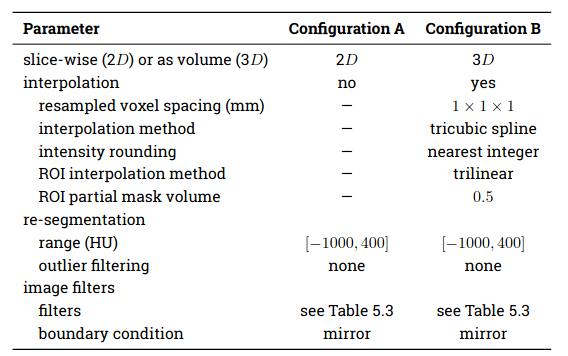

**Note**: The configuration *A* is 2D so it will not be tested (MEDomicsLab does not use slice wise computation).

### Dataset - CT image
We use the same CT image as in IBSI 1 phase 2. The image can be found here: [ibsi_1_ct_radiomics_phantom](https://github.com/theibsi/data_sets/tree/master/ibsi_1_ct_radiomics_phantom)

In [ ]:
import argparse
import math
import os
import pickle
import sys
from copy import deepcopy
from itertools import product
from json import dump, dumps
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from numpyencoder import NumpyEncoder

MODULE_DIR = os.path.dirname(os.path.abspath('../MEDimage/MEDimage.py'))
sys.path.append(os.path.dirname(MODULE_DIR))

import numpy as np
from MEDimage.MEDimage import MEDimage
from MEDimage.MEDimageComputeRadiomics import MEDimageComputeRadiomics
from MEDimage.MEDimageProcessing import MEDimageProcessing
from MEDimage.utils import jsonUtils
from numpyencoder import NumpyEncoder

In [ ]:
from MEDimage.processing.getROI_fromIndexes import getROI_fromIndexes
from MEDimage.processing.roiExtract import roiExtract

In [ ]:
def __getPathResults():
    _rp = Path(os.getcwd()) / "results/ibsi2/phase2"
    if not _rp.exists():
        Path.mkdir(_rp, parents=True)
    return _rp

### Configuration

The first step in this notebook is choosing the test ID (Test to run). Since only configuration B is implemented, we don't specify the configuration in the test ID .i.e. instead of test ID *5.B* we use test ID *5* Test IDs accepted : *1* *2* *3* *4* *5* *6* and *7* (equivalent to *1.B* *2.B* *3.B* *4.B* *5.B* *6.B* and *7.B* in the IBSI). Filters and parameters for the configurations B (ҎD) defined in the following table (The filter parameters for config *B* are in the second row of each test ID):

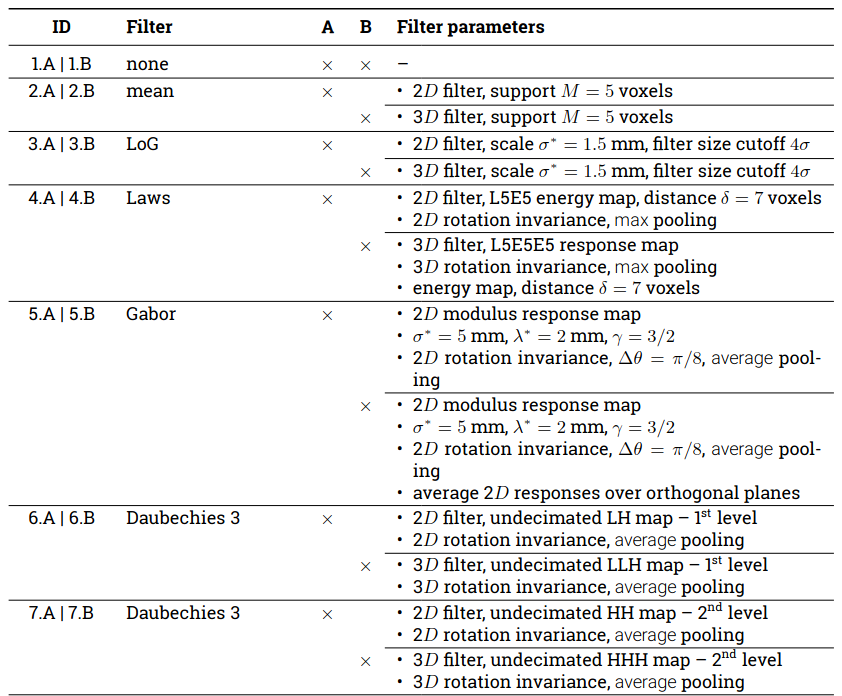

In [ ]:
test_id = '1' # test ID. More details about tests can be found in the IBSI chapter 2 reference

### Initialization (Untouchable)

File name should respect the following norm : 
- NPY format : PatientNameOrID__ImagingScanName.ImagingModality.npy
- NIFTI format : PatientNameOrID__ImagingScanName(tumorAuto).ImagingModality.nii.gz

In [ ]:
pathData = Path(os.getcwd()) / "data" # Path to the data folder
pathRead = pathData / 'CTimage' # Path to the CT-image folder
pathSettings = Path(os.getcwd()) / "settings" # Path to the settings/configuration folder

nameROI = '{GTV-1}' # Region of interest name
nameRead = "PAT1__CT(tumorAuto).CTscan.nii.gz" # CT image filename
roiType = ''

In [ ]:
def _initMEDimage(imParams):
    """
    Initializes the MEDimage class and the child classes.
    :param imParams : Dict of the test parameters.
    :return: Child classes (MEDimageProcessing and MEDimageComputeRadiomics).
    """ 
    if nameRead.endswith('.npy'):
        # MEDimage instance is now in Workspace
        with open(pathRead / nameRead, 'rb') as f: MEDimg = pickle.load(f)

        # MEDimageProcess instance is now in Workspace
        MEDimageProcess = MEDimageProcessing(MEDimg=MEDimg, log_file=pathRead /'log_file_ibsi1p2.txt')

        # MEDimageComputeRadiomics instance is now in Workspace
        MEDimageCR = MEDimageComputeRadiomics(MEDimg=MEDimg, log_file=MEDimageProcess.log_file)

        # Initialize processing & computation parameters
        MEDimageProcess.init_Params(imParamScan=imParams,
                                    imParamFilter=imParams['imParamFilter'],
                                    roiType=roiType)

        # Clear MEDimage instance # Clear up RAM
        MEDimg = None 

        return MEDimageProcess, MEDimageCR

    # Set up NIFTI Image path 
    NiftiImage = pathRead / nameRead

    # MEDimage instance is now in Workspace
    MEDimg = MEDimage()

    # Initialization using NIFTI file :
    MEDimg.init_from_nifti(NiftiImagePath=NiftiImage)

    # spatialRef Creation : 
    MEDimg.scan.volume.spatialRef_from_NIFTI(NiftiImage)

    # MEDimageProcess instance is now in Workspace
    MEDimageProcess = MEDimageProcessing(MEDimg=MEDimg, log_file=pathRead /'log_file_ibsi1p2.txt')

    # MEDimageComputeRadiomics instance is now in Workspace
    MEDimageCR = MEDimageComputeRadiomics(MEDimg=MEDimg, log_file=MEDimageProcess.log_file)

    # Initialize processing & computation parameters
    MEDimageProcess.init_Params(imParamScan=imParams,
                                imParamFilter=imParams['imParamFilter'],
                                roiType=roiType)

    # Clear MEDimage instance, clear up RAM
    MEDimg = None

    return MEDimageProcess, MEDimageCR

In [ ]:
def _init_MEDimage(_filename):
    """
    Initializes the MEDimage class and the child classes.
    :param _filename: The NIFTI filename that will be used in the test.
    :return: Child classes (MEDimageProcessing and MEDimageComputeRadiomics).
    """
    if not (_filename.endswith('.nii.gz') or _filename.endswith('.npy')):
        raise ValueError('the file name should have extension .nii.gz or .npy')
            
    
        
    nameRead = _filename 

    if _filename.endswith('.npy'):
        # MEDImage instance is now in Workspace
        with open(pathRead / _filename, 'rb') as f: MEDimg = pickle.load(f)

        # MEDImageProcess instance is now in Workspace
        MEDimageProcess = MEDImageProcessing(MEDimg=MEDimg, log_file=pathRead /'log_file_ibsi2_p2.txt')

        # MEDImageComputeRadiomics instance is now in Workspace
        MEDimgCR = MEDImageComputeRadiomics(MEDimg=MEDimg,log_file=MEDimageProcess.log_file)

        # Initialize processing & computation parameters
        MEDimageProcess.init_Params(imParamScan=imParams, 
                                    imParamFilter=imParams['imParamFilter'], 
                                    roiType=roiType)

        # Clear MEDimage instance # Clear up RAM
        MEDimg = None 

        return MEDimageProcess, MEDimgCR

    # Set up NIFTI Image path 
    NiftiImage = pathRead / nameRead

    # MEDImage instance is now in Workspace
    MEDimg = MEDImage()

    # Initialization using NIFTI file :
    MEDimg.init_from_nifti(NiftiImagePath=NiftiImage)

    # spatialRef Creation : 
    MEDimg.scan.volume.spatialRef_from_NIFTI(NiftiImage)

    # MEDImageProcessing instance is now in Workspace
    MEDimageProcess = MEDImageProcessing(MEDimg=MEDimg,log_file=pathRead /'log_file_ibsi2_p2.txt')

    # MEDImageComputeRadiomics instance is now in Workspace
    MEDimgCR = MEDImageComputeRadiomics(MEDimg=MEDimg,log_file=MEDimageProcess.log_file)

    # Initialize processing & computation parameters
    MEDimageProcess.init_Params(imParamScan=imParams, 
                                imParamFilter=imParams['imParamFilter'], 
                                roiType=roiType)
    
    # Clear MEDimage instance # Clear up RAM
    MEDimg = None

    return MEDimageProcess, MEDimgCR

In [ ]:
from MEDimage.processing.interpVolume import interpVolume

def _interpolate(MEDimageProcess, nameROI):
    """
    Runs voxel interpolation on MEDimage volume data and creates the intensity + morphological mask.
    :param MEDimageProcess: Instance of MEDImageProcessing.
    :param nameROI: The name of the region of interest used for the processing
    :return: Two volume objects (Intensity mask and the morphological mask).
    """
    volObjInit, roiObjInit = getROI_fromIndexes(MEDimageProcess, nameROI=nameROI, boxString='full')

    # --------> Intensity Mask :
    volObj = interpVolume(
        MEDimageProcess,
        volObjS=volObjInit,
        voxDim=MEDimageProcess.Params['scaleNonText'],
        interpMet=MEDimageProcess.Params['volInterp'],
        roundVal=MEDimageProcess.Params['glRound'],
        image_type='image',
        roiObjS=roiObjInit,
        boxString=MEDimageProcess.Params['boxString']
    )
    # --------> Morphological Mask :
    roiObj_Morph = interpVolume(
        MEDimageProcess,
        volObjS=roiObjInit,
        voxDim=MEDimageProcess.Params['scaleNonText'],
        interpMet=MEDimageProcess.Params['roiInterp'],
        roundVal=MEDimageProcess.Params['roiPV'], 
        image_type='roi',
        roiObjS=roiObjInit,
        boxString=MEDimageProcess.Params['boxString']
    )

    return volObj, roiObj_Morph

In [ ]:
from MEDimage.processing.rangeReSeg import rangeReSeg
from MEDimage.processing.outlierReSeg import outlierReSeg

def _resegment(MEDimageProcess, volObj, roiObj_Morph):
    """
    Outlier resegmentation of the ROI mask.
    :param MEDimageProcess: Instance of MEDImageProcessing.
    :param volObj: Filtered volume object.
    :param roiObj_Morph: Morphological mask.
    :return: Volume object of the intensity mask.
    """
    # Range Re-Segmentation :
    roiObj_Int = deepcopy(roiObj_Morph)
    roiObj_Int.data = rangeReSeg(vol=volObj.data, 
                                 roi=roiObj_Int.data,
                                 im_range=MEDimageProcess.Params['im_range']
    )
    # Outlier Re-Segmentation :
    roiObj_Int.data = np.logical_and(
        outlierReSeg(vol=volObj.data, roi=roiObj_Int.data, outliers=MEDimageProcess.Params['outliers']),
        roiObj_Int.data
    ).astype(int)
    
    return roiObj_Int

In [ ]:
def plot_comparison(result, original_data, _slice, test_id, filter_name):
    """
    Plot the coronal, axial and sagittal slices of the original image and the result image.
    :param result: The result obtained by the program.
    :param original_data: The original image
    :param _slice: Which slice will be plotted along each axis.
    :param test_id: The test identificator as string that will be used in the figure name. "Exemple: 2"
    :param filter_name: Name of the filter used.
    """
    if not filter_name:
        filter_name = 'no filter'
        
    if len(original_data.shape) > 3:
        original_data = np.squeeze(original_data)

    fig = plt.figure(figsize=(12, 12))
    fig.canvas.manager.set_window_title('Phase2_ID' + test_id + 'B')

    if original_data is not None:

        fig.suptitle(f'Original image vs Processed image using {filter_name}. (Test ID : {test_id}.B)', fontsize=16)

        fig.add_subplot(2, 3, 1, ylabel="Original image", title="Coronal")
        plt.imshow(original_data[:, :, _slice], cmap='gray')

        fig.add_subplot(2, 3, 2, title="Axial")
        plt.imshow(original_data[:, _slice, :], cmap='gray')

        fig.add_subplot(2, 3, 3, title="Sagittal")
        plt.imshow(original_data[_slice, :, :], cmap='gray')

        fig.add_subplot(2, 3, 4, ylabel="Result")
        plt.imshow(result[:, :, _slice], cmap='gray')

        fig.add_subplot(2, 3, 5)
        plt.imshow(result[:, _slice, :], cmap='gray')

        fig.add_subplot(2, 3, 6)
        plt.imshow(result[_slice, :, :], cmap='gray')

    else:
        fig.add_subplot(1, 3, 1, ylabel="Result")
        plt.imshow(result[0, :, :, _slice], cmap='gray')

        fig.add_subplot(1, 3, 2)
        plt.imshow(result[0, :, _slice, :], cmap='gray')

        fig.add_subplot(1, 3, 3)
        plt.imshow(result[0, _slice, :, :], cmap='gray')

    plt.show()

In [ ]:
def save_results(pathResults, test_id, DiagFeatures, IntHistFeatures, StatsFeatures):
    """
    Saves the results in a JSON file under the formatting : Results_P2.{test_id}B.json
    :param test_id: The test identificator as string. "Exemple: 2"
    :param IntHistFeatures: Dict of Intensity Histogram features.
    :param StatsFeatures: Dict of Statistical features.
    """

    results = { 'Diagnostics' : DiagFeatures,
                'intHist_3D' : IntHistFeatures,
                'stats_3D' : StatsFeatures}

    # save results in json file:
    with open(pathResults / f"Results_P2.{test_id}B.json", "w") as fp:   
        dump(results, fp, indent=4, cls=NumpyEncoder)

### Initilization :

As mentionned before, CT-scan have a voxel spacing of 1 so it's gonna be our voxel length and will be used to compute the kernel size for some filter.

In [ ]:
VOLEX_LENGTH = 1

Extract the right parameters/configurations for the script

In [ ]:
imParams = jsonUtils.loadjson(pathSettings / 'IBSI2Phase2B_settings.json')

In this notebook we are going to use the **MEDimage** class and its child **MEDimageProcessing** to filter the images. So the first step is to intialize the MEDimage class using **NIFTI** files.

In [ ]:
MEDimageProcess, MEDimageCR = _initMEDimage(imParams)

### Image processing :

Processing is done prior to image filtering. The processing steps are:
- Segmentation (Creation of ROI mask)
- Interpolation :
    - resampled voxel spacing (mm) : [1 × 1 × 1]
    - interpolation method : tricubic spline
    - intensity rounding : nearest integer
    - ROI interpolation method : trilinear
    - ROI partial mask volume : 0.5
- Re-segmentation :
    - range(HU) : [-1000, 400]
- Image filtering
- ROI extraction

**PS**: We assume that the IBSI chapter 1 is tested and the image processing steps are now clear, so no details are given here.

In [ ]:
volObjInit, roiObjInit = getROI_fromIndexes(MEDimageProcess, nameROI=nameROI, boxString='full')

#### Diagnostic features:
The diagnostic features are computed before and after re-segmentation and interpolation to indentify the issues with the implementation (if there is any).

##### Initial diagnostics

In [ ]:
from MEDimage.processing.getDiagFeatures import getDiagFeatures

# Extract initial diagnostic featues
DIAG_init = getDiagFeatures(volObjInit, roiObjInit, roiObjInit, 'initial')

#### Interpolation

In [ ]:
# Interpolate
volObj, roiObj_Morph = _interpolate(MEDimageProcess, nameROI)

Voxel spacing before and after interpolation

In [ ]:
# voxel spacing before interpolation
print('Before interp:', volObjInit.spatialRef.PixelExtentInWorldX, 
      volObjInit.spatialRef.PixelExtentInWorldY,
      volObjInit.spatialRef.PixelExtentInWorldZ)
# voxel spacing after interpolation
print('After interp:',volObj.spatialRef.PixelExtentInWorldX, 
      volObj.spatialRef.PixelExtentInWorldY,
      volObj.spatialRef.PixelExtentInWorldZ)
# Desired voxel spacing 
print('Desired voxel spacing is [1, 1, 1]')

#### Re-segmentation

In [ ]:
roiObj_Int = _resegment(MEDimageProcess, volObj, roiObj_Morph)

##### Post-processing diagnostics

In [ ]:
# Extract Diagnostic features after interpolation and re-segmentation
DIAG_reSeg = getDiagFeatures(volObj, roiObj_Int, roiObj_Morph, 'reSeg')

### Image filtering

Unlike the phase 1, we use the MEDimage method ***applyFilter()*** to filter the CT image. The method uses the same process as phase 1. 

The parameters needed are the filter name/type and the image volume object.

In [ ]:
test_id = "7" # Another chance to set the test_id. check the figures above for more details.

In [ ]:
test_id = str(test_id)
filter_name = ''

if test_id == "1":
    filter_name = ''

elif test_id == "2":
    filter_name = 'Mean'

elif test_id == "3":
    filter_name = 'LoG'

elif test_id == "4":
    filter_name = 'Laws'

elif test_id == "5":
    filter_name = 'Gabor'

elif test_id == "6":
    filter_name = 'Wavelet_db3_LLH'

elif test_id == "7":        
    filter_name = 'Wavelet_db3_HHH'

else:
    raise NotImplementedError

if filter_name:
    volObj = MEDimageProcess.applyFilter(filter_name, volObj)

#### ROI-Extraction

In [ ]:
volInt_RE = roiExtract(
    vol=volObj.data, 
    roi=roiObj_Int.data
)

#### Features computation

As mentionned in the IBSI, only part of the radiomics features standardised previously is gonna be computed. The features computed are : *satistical features* and *intensity histogram features*.

In [ ]:
# imports
from MEDimage.biomarkers.getIntHistFeatures import getIntHistFeatures
from MEDimage.biomarkers.getStatsFeatures import getStatsFeatures

# Preparation of computation :
MEDimageCR.init_NTF_Calculation(volObj)

# Extract statistical and intenisty-histogram features
# Intensity Histogram Features
IntHistFeatures = getIntHistFeatures(
        vol=volInt_RE
    )

# Stats Features
Stats = getStatsFeatures(
        vol=volInt_RE,
        intensity=MEDimageCR.Params['intensity']
    )

# Diagnostics Features
DiagFeatures = {
    'diag_n_voxel' : DIAG_init['roi_initial_Int_voxNumb'],
    'diag_n_voxel_interp_reseg' : DIAG_reSeg['roi_reSeg_Int_voxNumb'],
    'diag_mean_int_interp_reseg' : DIAG_reSeg['roi_reSeg_meanInt'],
    'diag_max_int_interp_reseg' : DIAG_reSeg['roi_reSeg_maxInt'],
    'diag_min_int_interp_reseg' : DIAG_reSeg['roi_reSeg_minInt']
    }

Print the features extraction results

In [ ]:
print(dumps(
    {'Diagnostics' : DiagFeatures, 
     'intHist_3D' : IntHistFeatures, 
     'stats_3D' : Stats}, 
    indent=4, 
    cls=NumpyEncoder)
     )

Finally we plot the before-and-after image filterting

In [ ]:
_slice = 31
plot_comparison(volObj.data, volObjInit.data, _slice=_slice, test_id=test_id, filter_name=filter_name)

Run this cell to save the results in JSON format on your machine

In [ ]:
#pathResults = __getPathResults() # Path to where the results are gonna be saved
#save_results(pathResults, test_id, DiagFeatures, IntHistFeatures, Stats)

The IBSI chapter 2 phase 2 features calcultation results for *Udes* Team have been already submitted and can be found here : [Latest submissions](https://ibsi.radiomics.hevs.ch/#ibsi2-phase2-pane).